In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import src
from testingUtils import testing_main as tm
import matplotlib.pyplot as plt
import numpy as np


import src
from src.nc4.BJDSprialScan import processExpSprialScans, spiralPlotter
# import matplotlib as mp
# mpl.use('TkAgg')
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

# Testing Main Notebook

`testing_main.py` contains multiple functions:
- `main()`: choose an exp to load in, update and save it.
- `update(exp)`: update exp with new data, and display nc4.
- `check_ae(exp)`: plot last file of AE data in test.
- `check_nc4(exp)`: calc last NC4 file attributes and plot results.

----------------------TESTING EXP FILE----------------------
Test No: 21
Date: 2024-08-14
Data: ..\..\AE\Testing\24_08_14_weartest_D1.3_#1000
No. Files: AE-107 NC4-108
------------------------------------------------------------
------------------------------------------------------------
NC4 - File 107:
	Mean radius = 0.610684 mm
	Runout = 0.111 um
	Wear = -7.524 %
------------------------------------------------------------


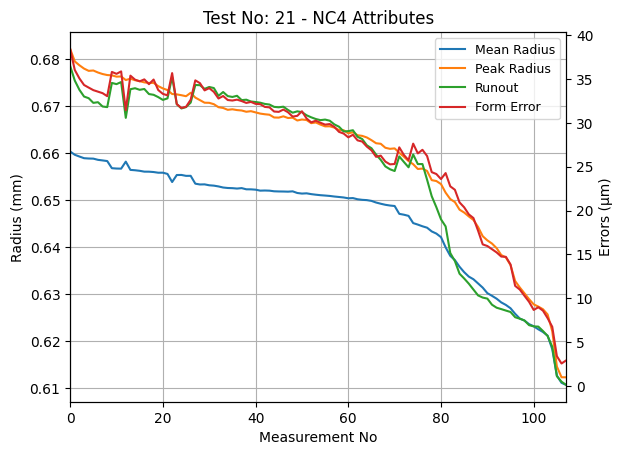

In [3]:
exp = tm.main()

In [4]:
exp.save()

In [ ]:
f = tm.update(exp)

In [ ]:
tm.check_ae(exp)

In [ ]:
exp.nc4.process()

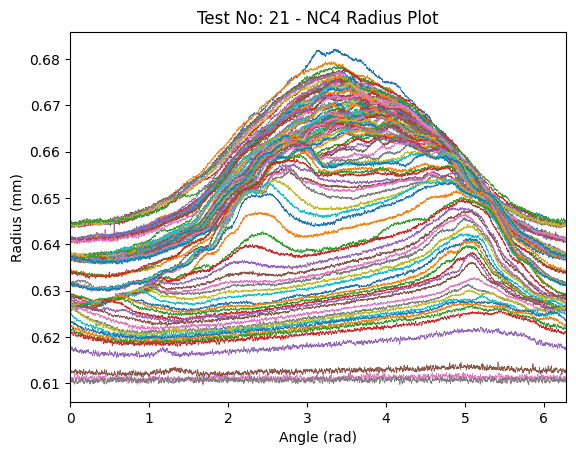

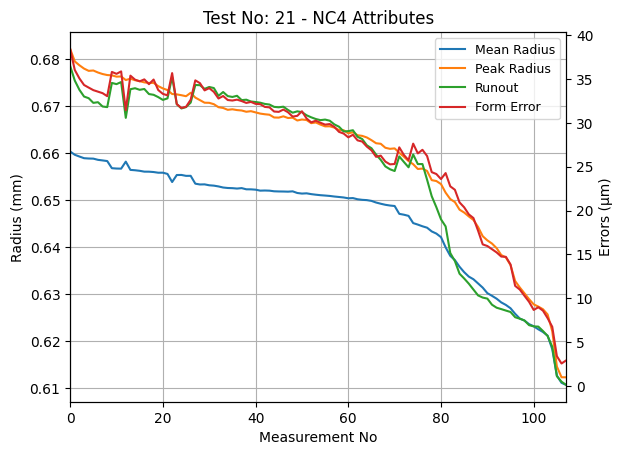

In [5]:
fno = (0, None)
f = exp.nc4.plot_xy(fno)
f = exp.nc4.plot_att(fno)

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Test No: 21 - NC4 Radius Surface'}, xlabel='Angle (rad)', ylabel='Measurement Number'>)

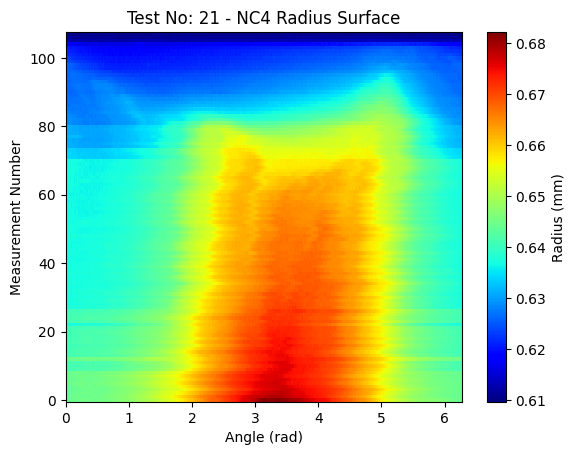

In [6]:
exp.nc4.plot_surf(fno)

In [ ]:
exp.save()

In [ ]:
# NC4 Spiral Scans
NOM_DIA = 1.3
FEEDRATE = 2
RPM = 60
FS = 50_000
YOFFSET = 0.03
CALFEEDRATE = 60

SCPath = CODE_DIR.joinpath(
    r'src/reference/NC4_BJD_SCurve_2024_05_30_14_17_12-Ch0-50kHz.tdms'
)
assert SCPath.exists(), "SCurve calibration file not found."

expSpiralScans = processExpSprialScans(exp,
                                       SCPath,
                                       NOM_DIA,
                                       FEEDRATE,
                                       RPM,
                                       FS,
                                       YOFFSET,
                                       CALFEEDRATE,
                                       )

for sc in expSpiralScans:
    fig, ax = sc.plotSpiralScan(saveFig=True)
    plt.close(fig)

In [ ]:
# %matplotlib widget
scPlotter = spiralPlotter(expSpiralScans, exp.test_info.testno).plot()

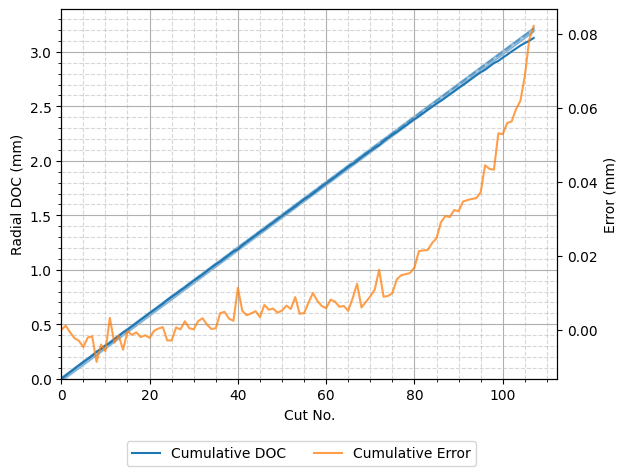

In [7]:
exp.probe
exp.probe.refreshProbeData()
if exp.probe is not None:
    fig, ax = exp.probe.plot_probe_DOC()
    ax.minorticks_on()
    ax.grid(True, which='major')
    ax.grid(True, which='minor', linestyle='--', alpha=0.5)
    # ax.set_xlim(0, 108)


### Extra Processing - Wait till CUSP

In [ ]:
exp.ae.process()

In [ ]:
exp.save()

In [ ]:
exp.create_feat_df();

In [ ]:
exp.save()

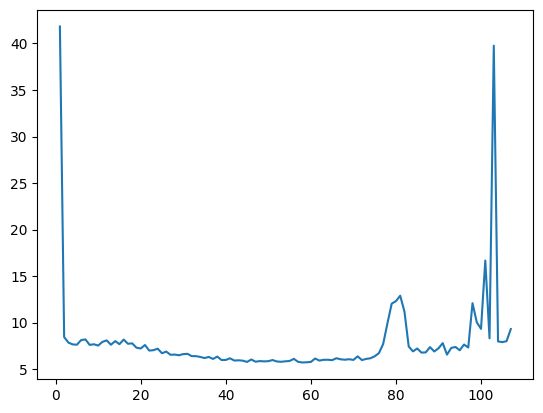

In [8]:
plt.figure()
plt.plot(exp.features['Kurtosis'])

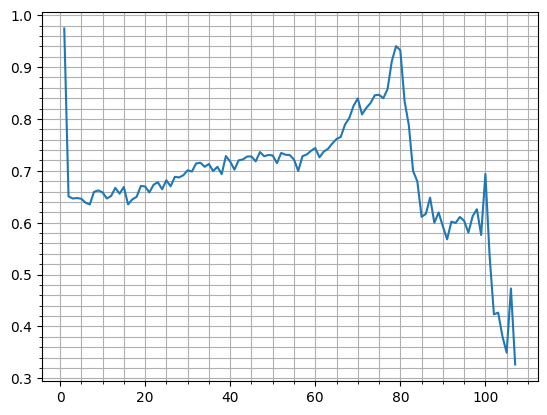

In [14]:
plt.figure()
plt.plot(exp.features['RMS'])
plt.minorticks_on()
plt.grid(True, which='both')

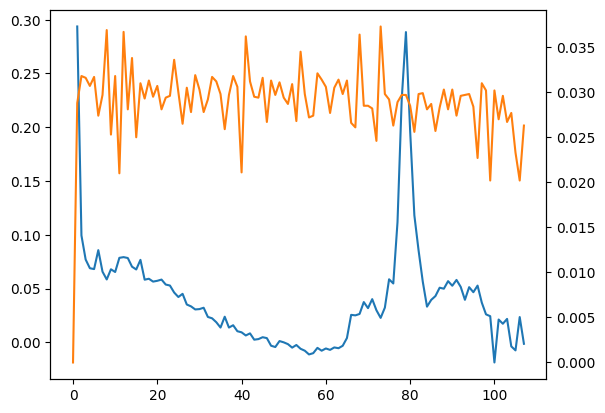

In [20]:
plt.figure()
plt.plot(exp.features['Skewness'])
# plt.ylim(2, 10)
plt.twinx()
plt.plot(exp.features['Probe diff'], 'C1')
# plt.plot(exp.features['Runout'], 'C1')

In [ ]:
nc4_df = exp.features.loc[:, ['Mean radius', 'Peak radius', 'Runout', 'Form error']]
nc4_df.head()
nc4_df.to_csv(fr'{exp.dataloc}\NC4Data.csv')